## Trabalho 4: Inversão de dados sintéticos de tomografia sísmica pelo método do gradiente conjugado aplicado as equações normais
### Disciplina: Problemas Inversos II
### Professor: Raphael Vieira Menezes de Souza
### Aluno: Matheus Klatt


1) Importando os módulos que contém as funções necessárias a realização do trabalho

In [1]:
#1)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics, linear_model, preprocessing
import seaborn as sns
%matplotlib inline

2) Leitura do arquivo "tomo.txt", o qual contém na primeira coluna um inteiro que identifica o raio e na segunda coluna o tempo de chegada do raio no receptor

In [2]:
#2)
trab4_df=pd.read_csv("tomo.txt",header=None,sep="\t",names=["Raio","d"])

3) Visualizando o dataframe que contém os dados, e verificando que foram lidos, criados e agrupados corretamente

In [3]:
#3)
trab4_df

,Raio,d
0,1,0.00400
1,2,0.00400
2,3,0.00267
3,4,0.00267
4,5,0.00400
5,6,0.00400
6,7,0.00267
7,8,0.00267
8,9,0.00141
9,10,0.00283


4) Em problemas inversos de tomografia sísmica o meio no qual os raios se deslocam é comumente discretizado em blocos de dimensões uniformes. Aqui tratamos de um meio simples de geometria quadrada e $L = 4$ m de lado discretizado em blocos também quadrados de $l = 1$ m de lado, conforme a figura a seguir:

<img src="model_py.png"/>

Nesta parametrização os elementos de $\mathbf{G}_{m x n}$ são simplesmente o comprimento da trajetória dos raios em cada um dos $s_{k}$ blocos percorridos por cada raio. Considerando as trajetórias de 22 raios disparados com a seguinte geometria:

<img src="tomo_real_model.png"/>

Na matriz $\mathbf{G}$ cada uma das $m = 22$ linhas corresponde a um dos raios, em ordem crescente de $t_{1}$ a $t_{22}$. Por sua vez as $n = 16$ colunas correspondem a cada um dos $s_{k}$ blocos da discretização do meio físico, da esquerda para a direita de $s_{1}$ a $s_{16}$. Portanto $\mathbf{G}$ será escrita da seguinte forma:

$\begin{equation}
\mathbf{G}_{22 x 16}
=
\begin{bmatrix}
1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 \\
 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 \\
\sqrt{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & \sqrt{2} & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & \sqrt{2} & 0 & 0 & \sqrt{2} & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & \sqrt{2} & 0 & 0 & \sqrt{2} & 0 & 0 & \sqrt{2} & 0 & 0 & \sqrt{2} & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & \sqrt{2} & 0 & 0 & \sqrt{2} & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & \sqrt{2} & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sqrt{2}\\
0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & \sqrt{2} & 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 \\
\sqrt{2} & 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & \sqrt{2}\\
0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & \sqrt{2} & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0
\end{bmatrix}
\end{equation}$

Dimensões dos elementos do problema inverso, G, d e m_real: 
 Shape G:  (22, 16) Shape d:  (22, 1) Shape m_real:  (4, 4) 

Velocidades do modelo real em m/s: 
 [[1000. 1000. 1000. 1000.]
 [1000. 1000. 1000. 1000.]
 [1000. 1000. 3000. 3000.]
 [1000. 1000. 3000. 3000.]]


Text(0.5, 1.0, 'Representação esquemática de G:')

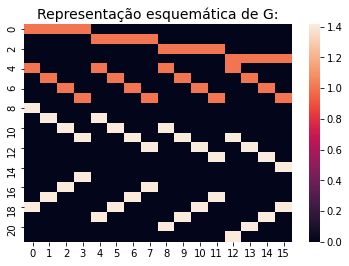

In [4]:
#4) Montagem de matrizes e vetores do problema, G, d e m.

# Construção de G conforme detalhado em 4)
G=np.zeros((22,16),dtype=np.float32)

G[0,0:4]=1.0 #t1
G[1,4:8]=1.0 #t2
G[2,8:12]=1.0 #t3
G[3,12:16]=1.0 #t4

G[4,[0,4,8,12]]=1.0 #t5
G[5,[1,5,9,13]]=1.0 #t6
G[6,[2,6,10,14]]=1.0 #t7
G[7,[3,7,11,15]]=1.0 #t8

G[8,[0]]=np.sqrt(2) #t9
G[9,[1,4]]=np.sqrt(2) #t10
G[10,[2,5,8]]=np.sqrt(2) #t11
G[11,[3,6,9,12]]=np.sqrt(2) #t12
G[12,[7,10,13]]=np.sqrt(2) #t13
G[13,[11,14]]=np.sqrt(2) #t14
G[14,[15]]=np.sqrt(2) #t15

G[15,[3]]=np.sqrt(2) #t16
G[16,[2,7]]=np.sqrt(2) #t17
G[17,[1,6,11]]=np.sqrt(2) #t18
G[18,[0,5,10,15]]=np.sqrt(2) #t19
G[19,[4,9,14]]=np.sqrt(2) #t20
G[20,[8,13]]=np.sqrt(2) #t21
G[21,[12]]=np.sqrt(2) #t22


# Construção do vetor de dados observados d, o qual contém os tempos de trânsito de cada um dos raios
d=trab4_df["d"].to_numpy().reshape((-1,1))

# Construção do vetor m_real, o qual guarda as velocidades reais do meio em subsuperficie discretizada como 
# mostrado em 4)
m_real=np.array([1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,3000,3000,1000,1000,3000,3000],
                        dtype=np.float32).reshape((4,4))

# Verificando que G, d e m tem dimensões corretas
print("Dimensões dos elementos do problema inverso, G, d e m_real: \n",
      "Shape G: ",G.shape,"Shape d: ",d.shape,"Shape m_real: ",m_real.shape,"\n")

# Verificando que os valores de velocidade do modelo real estao corretos
print("Velocidades do modelo real em m/s: \n",m_real)

# Verficando que os valores dos elementos de G estao de acordo com o exibido em 4)
fig, (ax1) = plt.subplots(1,1)
sns.heatmap(G,ax=ax1)
ax1.set_title("Representação esquemática de G:",fontsize=14)



5) Os métodos iterativos para resolução de problemas inversos são especialmente úteis quando a problema tratado é de grande escala e a matriz $\mathbf{G}_{m x n}$ possui mais de dezenas de milhares de linhas e colunas. Especificamente, quanto menos esparsa for $\mathbf{G}_{m x n}$ maiores serão os custos computacionais para o uso de métodos diretos de resolução.

Um destes métodos iterativos é o do gradiente conjugado. Este método em si só pode ser aplicado a sistemas de equações simétricos e positivo definidos, mas a formulação do problema como um problema de mínimos quadrados 

$\begin{equation}
min \lvert\lvert\mathbf{G}\mathbf{m} - \mathbf{d}\rvert\rvert_{2}
\end{equation}$,

permite a aplicação do gradiente conjugado as equações normais

$\begin{equation}
\mathbf{G}^{T}\mathbf{G}\mathbf{m} = \mathbf{G}^{T}\mathbf{d}
\end{equation}$

Essencialmente o método constrói ao longo de $k$ iterações uma sequencia de vetores solução $\mathbf{m}^{(k)}$ pelo seguinte algoritmo até que os critérios estabelecidos de convergência sejam satisfeitos:

Iniciando as $k$ iterações com $k = 0$, $\mathbf{m}^{(0)} = \mathbf{0}$, $\mathbf{p}^{(-1)} = \mathbf{0}$, $\beta^{(0)} = 0$, $\mathbf{s}^{(0)} = \mathbf{d} - \mathbf{G}\mathbf{m}^{(0)}$, e $\mathbf{r}^{(0)} = \mathbf{G}^{T}\mathbf{s}^{(0)}$

$\textbf{enquanto}$ $(k < $ número máximo de iterações $)$ $\textbf{faça}$
<ol>
<li>$\beta^{(k)} = \dfrac{\mathbf{r}^{(k)T}\mathbf{r}^{(k)}}{\mathbf{r}^{(k-1)T}\mathbf{r}^{(k-1)}}$</li>

<li>$\mathbf{p}^{(k)} = \mathbf{r}^{(k)} +  \beta^{(k)}\mathbf{p}^{(k-1)}$</li>

<li>$\alpha^{(k)} = \dfrac{\lvert\lvert\mathbf{r}^{(k)}\rvert\rvert_{2}^{2}}{(\mathbf{p}^{(k)T}\mathbf{G}^{T})(\mathbf{G}\mathbf{p}^{(k)})}$</li>

<li>$\mathbf{m}^{(k+1)} = \mathbf{m}^{(k)} + \alpha^{(k)}\mathbf{p}^{(k)}$</li>

<li>$\mathbf{s}^{(k+1)} = \mathbf{s}^{(k)} - \alpha^{(k)}\mathbf{G}\mathbf{p}^{(k)}$</li>

<li>$\mathbf{r}^{(k+1)} = \mathbf{G}^{T}\mathbf{s}^{(k+1)}$</li>

<li>$k = k + 1$</li>
</ol>

Dentre as propriedades vantajosas do método do gradiente conjugado de mínimos quadrados ($\textit{conjugate gradient least squares}$), CGLS, estão o fato da norma dos parâmetros do modelo $\lvert\lvert\mathbf{m}^{(k)}\rvert\rvert_{2}$ aumentar monotonicamente a cada iteração e da norma dos resíduos $\lvert\lvert\mathbf{d} - \mathbf{G}\mathbf{m}^{(k)}\rvert\rvert_{2}$ diminuir monotonicamente a cada iteração. Esta característica permite definir um critério de parada do algoritmo baseado na magnitude dos resíduos, o que funciona como uma forma de regularização da solução. Então uma verificação adicional pode ser incoporada antes do primeiro item do laço de $k$ iterações descrito acima

- se $\lvert\lvert\mathbf{d} - \mathbf{G}\mathbf{m}^{(k)}\rvert\rvert_{2} < \tau$, parar o algoritmo, criterio de tolerância satisfeito. 



In [5]:
#5) Definição da função que implementa o algoritmo descrito em 5) 
# para o método de gradiente conjugado de mínimos quadrados (CGLS). A função CGLS_ recebe como parâmetros
# o vetor de dados d e a matriz G, e possui como parâmetros opcionais o número máximo de iterações do algoritmo (kmax)
# e também o critério de tolerância (tol) que deve ser atingido para que o método tenha sua execução interrompida
# a função CGLS_ retorna as seguintes informações: ultimo modelo m^{k} obtido pelo algoritmo antes de ser
# interrompido, assim como as últimas instancias de cada uma das variaveis r^{k},beta_{k-1},p^{k-1},s^{k},
# as duas listas contendo as normas das soluções, mnl, e normas dos resíduos, rnl, 
# obtidas em todas as iterações até a parada e também o número total de iterações processadas, k.
# No código abaixo, cada um dos passos do algoritmo descrito em 5) esta assinalado com a mesma numeração da lista 
# que detalha os passos, no formato: #1., #2., #3., #4., #5., #6., #7..
def CGLS_(d,G,kmax=1000,tol=0.000001):
    # Inicialização de m^{0} = 0.
    m0=np.zeros((len(G[0,:]),1))
    # Inicialização de beta_{0} = 0.
    beta0=0.
    # Inicialização de p^{-1} = 0.
    p0=np.zeros((len(G[0,:]),1))
    # Inicialização de s^{0} = d - Gm^{0}
    s0=np.add(np.copy(d),-np.matmul(G,m0))
    # Inicialização de r^{0} = G.Ts^{0}
    r0=np.matmul(G.T,s0)
    # Inicialização da variável que guarda a iteração atual k=0
    k=0
    # Lista que todas as normas das soluções obtidas até término da execução
    mnl=[]
    # Lista que todas as normas dos resíduos obtidos até término da execução
    rnl=[]

    while (k < kmax):
        # condição que verifica se criterio de tolerancia foi atingido
        if (np.linalg.norm(np.add(d,-np.matmul(G,m0)),2)< tol):
            print("Tolerance value of ", tol, " reached")
            break
        # condição para evitar divisão por r^{0}=0. na primeira iteração    
        if (k>0): 
        #1.
            betak=np.matmul(r0.T,r0)/np.matmul(r_aux.T,r_aux)
            # Guardando normas da solução e resíduos nas respectivas listas mnl e rnl
            mnl.append(np.linalg.norm(m0,2))
            rnl.append(np.linalg.norm(np.add(d,-np.matmul(G,m0)),2))
        # na primeira iteração, k=0, beta^{k}=beta^{0}
        else:
            betak=beta0
        #2.
        pk=r0+betak*p0
        #3.
        alfak=np.linalg.norm(r0,2)**2/(np.matmul(np.matmul(pk.T,G.T),np.matmul(G,pk))+1e-8)
        #4.
        mk=m0+alfak*pk
        #5.
        sk=s0 - alfak*np.matmul(G,pk)
        #6.
        rk=np.matmul(G.T,sk)
        
        # Atualização dos valores de vetores e matrizes para próxima iteração
        #r_{k-1} = r_{k}
        r_aux=r0
        #r_{k} = r_{k+1}
        r0=rk
        #p_{k-1} = p_{k}
        p0=pk
        #m_{k} = m_{k+1}
        m0=mk
        #s_{k} = s_{k+1}
        s0=sk
        
        #7.
        k=k+1
        
        # Exibição do número de iterações realizadas
        if (k%(kmax/10)==0.):
            print("Iteration ",k, " of ",kmax)
            
    return(m0,r0,beta0,p0,s0,mnl,rnl,k)

m_k,r_0,beta_0,p_0,s_0,mnl,rnl,k=CGLS_(d,G,1000)

Iteration  100  of  1000
Iteration  200  of  1000
Iteration  300  of  1000
Iteration  400  of  1000
Iteration  500  of  1000
Iteration  600  of  1000
Iteration  700  of  1000
Iteration  800  of  1000
Iteration  900  of  1000
Iteration  1000  of  1000


6) Começamos a avaliação do modelo $\mathbf{m}^{(k)}$ obtido do método CGLS pela análise da curva de norma das soluções $\lvert\lvert\mathbf{m}^{(k)}\rvert\rvert_{2}$,  contra a norma dos resíduos, $\lvert\lvert\mathbf{d} - \mathbf{G}\mathbf{m}^{(k)}\rvert\rvert_{2}$.

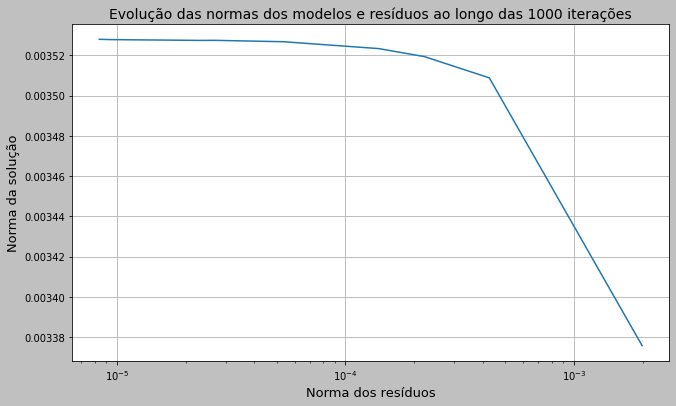

In [6]:
#6) Exibição da curva "L" resultante da aplicação do algoritmo CGLS

fig_L, (ax1)=plt.subplots(1,1,figsize=(10.7,6.2))
fig_L.set_facecolor("silver")

ax1.semilogx(rnl,mnl)
ax1.set_title('Evolução das normas dos modelos e resíduos ao longo das {} iterações'.format(k),fontsize=14)
ax1.set_xlabel('Norma dos resíduos',fontsize=13)
ax1.set_ylabel('Norma da solução',fontsize=13)
ax1.grid()

7) A segunda parte consiste na comparação direta entre os parâmetros (velocidades) reais $\mathbf{m}_{real}$ e os obtidos pelo CGLS em $\mathbf{m}^{(k)}$. A discrepância entre os dois é medida pela diferença absoluta $\lvert\mathbf{m}^{(k)} - \mathbf{m}_{real}\rvert$ .

Text(0.5, 100.25011764705883, 'Distância horizontal (m)')

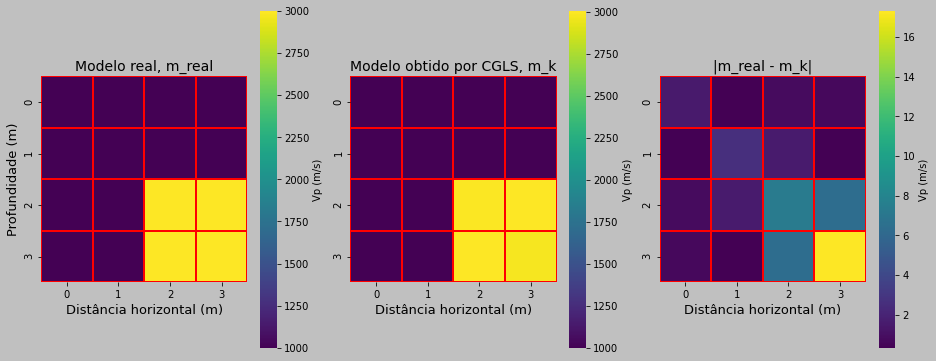

In [7]:
#7) Visualização dos modelos de velocidade, real (m_real), estimado pelo CGLS (m^{(k)}) e 
# da diferença absoluta entre eles |m^{(k) - m_real|
fig_L, (ax1)=plt.subplots(1,3,figsize=(15.7,6.2))
fig_L.set_facecolor("silver")
sns.heatmap(m_real,ax=ax1[0],square=True,cmap="viridis",linewidth=1,linecolor="red",
           cbar_kws={'label': 'Vp (m/s)'})
sns.heatmap(1/m_k.reshape((4,4)),ax=ax1[1],square=True,cmap="viridis",linewidth=1,linecolor="red",
           cbar_kws={'label': 'Vp (m/s)'})
sns.heatmap(abs(m_real-1/m_k.reshape((4,4))),ax=ax1[2],square=True,cmap="viridis",linewidth=1,linecolor="red",
           cbar_kws={'label': 'Vp (m/s)'})
ax1[0].set_title("Modelo real, m_real",fontsize=14)
ax1[1].set_title("Modelo obtido por CGLS, m_k",fontsize=14)
ax1[2].set_title("|m_real - m_k|",fontsize=14)

ax1[0].set_xlabel('Distância horizontal (m)',fontsize=13)
ax1[0].set_ylabel('Profundidade (m)',fontsize=13)
ax1[1].set_xlabel('Distância horizontal (m)',fontsize=13)

ax1[2].set_xlabel('Distância horizontal (m)',fontsize=13)



In [8]:
#8) Visualização quantitativa exata dos parâmetros do modelo real, m_real, modelo calculado com CGLS, m_k,
# e da diferença absoluta entre os dois |m_k - m_real|
print("Modelo de velocidades real, m_real: \n",(m_real),"\n")
print("Modelo de velocidades obtido do CGLS, m^{(k)}: \n",(1/m_k).reshape((4,4)),"\n")
print("Diferença absoluta entre modelo estimado e modelo real, |m_k-m_real|: \n",
      abs((1/m_k).reshape((4,4))-m_real),"\n")


Modelo de velocidades real, m_real: 
 [[1000. 1000. 1000. 1000.]
 [1000. 1000. 1000. 1000.]
 [1000. 1000. 3000. 3000.]
 [1000. 1000. 3000. 3000.]] 

Modelo de velocidades obtido do CGLS, m^{(k)}: 
 [[1001.50276118  999.63774404  999.18314967 1000.69764283]
 [ 999.63774404 1002.62362238  998.44984751  999.66633844]
 [ 999.18314967  998.44984751 2992.64347084 3006.35915332]
 [1000.69764283  999.66633844 3006.35915332 2982.67970853]] 

Diferença absoluta entre modelo estimado e modelo real, |m_k-m_real|: 
 [[ 1.50276118  0.36225596  0.81685033  0.69764283]
 [ 0.36225596  2.62362238  1.55015249  0.33366156]
 [ 0.81685033  1.55015249  7.35652916  6.35915332]
 [ 0.69764283  0.33366156  6.35915332 17.32029147]] 



### Conclusão

Embora a situação tratada no trabalho tenha sido de uma tomografia sísmica relativamente simples com modelo de velociddades de dimensões pequenas, foi possível observar o potencial do método iterativo CGLS, principalmente em relação a capacidade de convergência. A maior diferença absoluta observada entre parâmetros do modelo real $\mathbf{m}_{real}$ e do modelo estimado pelo CGLS $\mathbf{m}^{(k)}$ foi de menos de 1% (17.32 m/s para um valor real de 3000.0 m/s) do valor real do parâmetro considerado.

#### Referências

Aster, R., Borchers, B., Thurber, C., Parameter Estimation and Inverse Problems, Third Edition, Elsevier Academic Press, 404 pp., 2018. 

In [1]:
####################################################################################################################